In [1]:
import tensorflow as tf
import sonnet as snt
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
img_size = 10, 10
crop_size = 5, 5

x = abs(np.random.randn(1, *img_size)) * .3
x[0, 3:6, 3:6] = 1

In [4]:
tf.reset_default_graph()
# constraints = snt.AffineWarpConstraints.no_shear_2d()
constraints = snt.AffineWarpConstraints.no_constraints()
warper = snt.AffineGridWarper(img_size, crop_size, constraints)

print 'num transform params =', constraints.num_free_params

tx = tf.placeholder(tf.float32)
transform_params = tf.placeholder(tf.float32, [1, constraints.num_free_params], 'transform_params')


grid_coords = warper(transform_params)

stn_crop = snt.resampler(tx, grid_coords)

inverted_warper = warper.inverse()
inverted_coords = inverted_warper(transform_params)
inverted_crop = snt.resampler(stn_crop, inverted_coords)

sess = tf.Session()

num transform params = 6


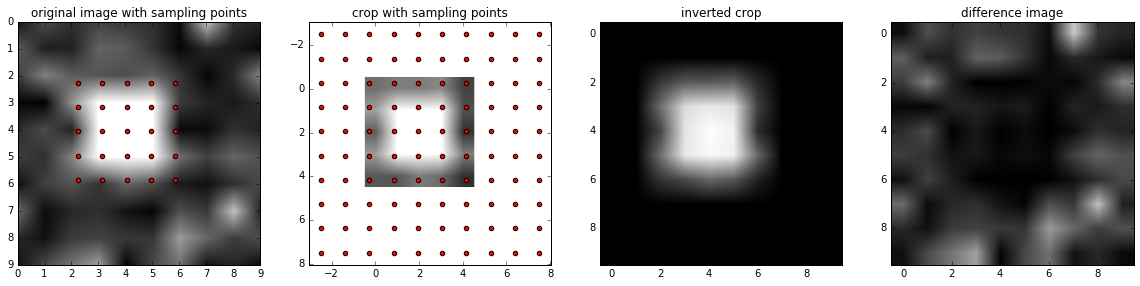

In [19]:
# transform = [.4, -.1, .4, -.1]
# transform = [.4, 0, -.1, 0, .4, -.1]
transform = [.4, 0, -.1, 0, .4, -.1]

transform = np.asarray(transform).reshape(transform_params.get_shape().as_list())

inpts = [stn_crop, grid_coords, inverted_crop, inverted_coords]
fd = {tx: x[..., np.newaxis], transform_params: transform}
stn_x, coords, ix, icoords = sess.run(inpts, fd)
coords, icoords = [i.reshape((-1, 2)) for i in (coords, icoords)]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(x.squeeze(), cmap='gray', vmin=0., vmax=1.)
ax[0].scatter(coords[:, 0], coords[:, 1], c='r')
ax[0].set_xlim([0, img_size[1]-1])
ax[0].set_ylim([img_size[0] -1, 0])


ax[1].imshow(stn_x.squeeze(), cmap='gray', vmin=0., vmax=1.)
ax[1].scatter(icoords[:, 0], icoords[:, 1], c='r')

ax[2].imshow(ix.squeeze(), cmap='gray', vmin=0., vmax=1.)

ax[3].imshow((x.squeeze() - ix.squeeze()), cmap='gray', vmin=0., vmax=1.)

titles = ['original image with sampling points', 'crop with sampling points', 'inverted crop', 'difference image']
for a, t in zip(ax, titles):
    a.set_title(t)

In [ ]:
fig.savefig('stn_demo.png', dpi=300)